In [3]:
import numpy as np
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import *
from qiskit.algorithms.optimizers import GradientDescent, ADAM, L_BFGS_B
from qiskit.quantum_info.operators import Operator
from qiskit.primitives import Estimator
from qiskit.circuit import Parameter
from qiskit.quantum_info import DensityMatrix
from scipy.optimize import *
import matplotlib.pyplot as plt
from qiskit.algorithms import VarQITE
from qiskit.algorithms.time_evolvers.variational import ImaginaryMcLachlanPrinciple
from qiskit.algorithms import TimeEvolutionProblem
from qiskit.quantum_info import *
import pylab
from qiskit.algorithms import SciPyImaginaryEvolver
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt 

/var/folders/dk/2y17dwn916n0849gyw2c2q3c0000gn/T/ipykernel_1145/3060990025.py:5: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import GradientDescent, ADAM, L_BFGS_B


In [41]:
def Ising(h,N):
    def krZ(m, N):
        matrix = np.array(1)
        for j in range(N):
            if m == j:
                matrix = np.kron(matrix, ZGate())     
            else:
                matrix = np.kron(matrix, IGate())
        return matrix  
    def krX(m, N):
        matrix = np.array(1)
        for j in range(N):
            if m == j:
                matrix = np.kron(matrix, XGate())     
            else:
                matrix = np.kron(matrix, IGate())
        return matrix  
    ising_mat = 0
    for l in range(N):
        if l+1 < N:
            ising = - np.matmul(krZ(l,N),krZ(l+1,N)) - h*krX(l,N)
            ising_mat = ising_mat + ising
        else:
            ising_mat = ising_mat + h*krX(l,N)
    return ising_mat    

In [43]:
Ising(1,2)

array([[-1.+0.j,  1.+0.j, -1.+0.j,  0.+0.j],
       [ 1.+0.j,  1.+0.j,  0.+0.j, -1.+0.j],
       [-1.+0.j,  0.+0.j,  1.+0.j,  1.+0.j],
       [ 0.+0.j, -1.+0.j,  1.+0.j, -1.+0.j]])

In [24]:
def Ansatz_varqite(N, depth):
    circuit = QuantumCircuit(N)
    thetas = []
    for l in range(N*(depth+1)):
        thetas.append(Parameter('θ_'+str(l)))
    counter = 0
    for j in range(N):
        if j+counter < N:
            circuit.ry(thetas[j + counter],j + counter)
        if j+1+counter < N:
            circuit.rx(thetas[j + 1 + counter],j + counter)
        if j+1+counter < N:
            circuit.cx(j+counter,(j+1)+counter)
        counter = counter + 1
    
    counter_3 = 0
    for i in range(depth):
        circuit.barrier()
        counter_2 = 0
        
        for l in range(N):
            if l +counter_2 + counter_3< len(thetas):
                   circuit.ry(thetas[l + counter_2 +counter_3+ N], l + counter_2)
        counter_3 = counter_3 + N     
        for p in range(N):
            circuit.cx(p,(p+1) % N)
          
    
    return circuit
        

In [49]:
hamiltonian = Operator(Ising(0,6))
var_principle = ImaginaryMcLachlanPrinciple()
time = 2.0
aux_ops = [hamiltonian]
init_param_values =  [np.pi/2, np.pi]*3 + [0]*12
ansatz = Ansatz_varqite(6,2)
evolution_problem = TimeEvolutionProblem(hamiltonian, time, aux_operators=aux_ops)
var_qite = VarQITE(ansatz, init_param_values, var_principle, Estimator())
evolution_result = var_qite.evolve(evolution_problem)

In [50]:
init_state = Statevector(ansatz.assign_parameters(init_param_values))
evolution_problem = TimeEvolutionProblem(hamiltonian, time, initial_state=init_state, aux_operators=aux_ops)
exact_evol = SciPyImaginaryEvolver(num_timesteps=200)
sol = exact_evol.evolve(evolution_problem)

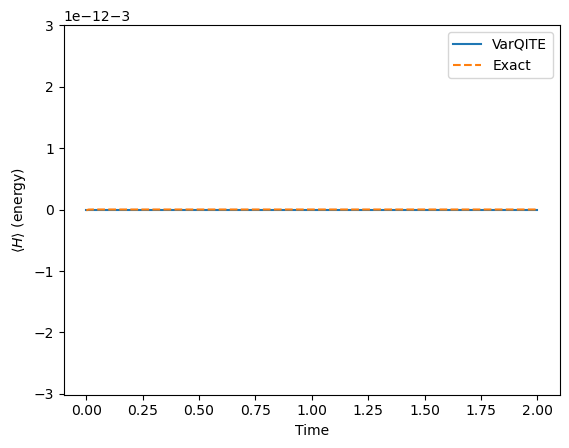

In [51]:
h_exp_val = np.array([ele[0][0] for ele in evolution_result.observables])

exact_h_exp_val = sol.observables[0][0].real

times = evolution_result.times
pylab.plot(times, h_exp_val, label= "VarQITE")
pylab.plot(times, exact_h_exp_val , label= "Exact",  linestyle='--')
pylab.xlabel("Time")
pylab.ylabel(r"$\langle H \rangle$ (energy)")
pylab.legend(loc="upper right");

In [47]:
rho = DensityMatrix(evolution_result.evolved_state)
rho_a = partial_trace(state=rho, qargs=[1,3,5])

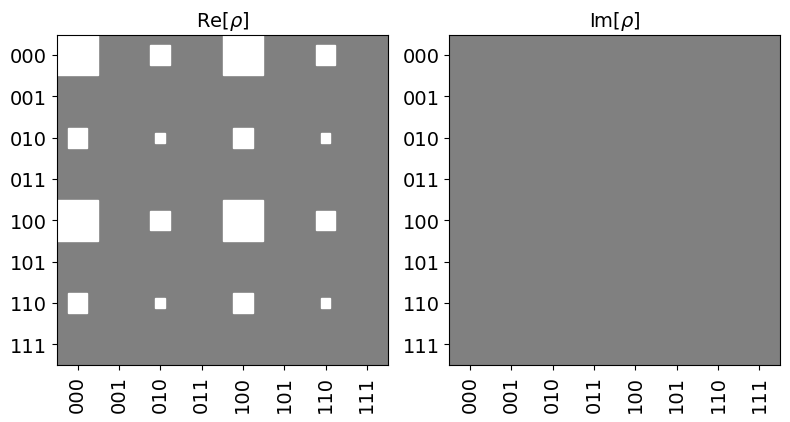

In [48]:
rho_a.draw(output = 'hinton')